# Simulation Development  

This notebook is for developing the next iteration of our simulation for Theory of Mind. This simulation runs on numpy and uses planning algorithms to enable agents to solve a goal based environment.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
class Simulation:
    """
    Parent simulation class for collecting agent trajectories and associated information.
    
    This class is designed to store data that will later be used for modeling, such as 
    the full trajectories of agents and their assigned goals.
    """
    def __init__(self):
        # Dictionary to store trajectories, keyed by agent ID.
        # Each trajectory can be a list (or array) of (x, y) tuples.
        self.agent_trajectories = {}
        # Dictionary to store each agent's goal.
        self.agent_goals = {}
    
    def add_agent_trajectory(self, agent_id, trajectory, goal):
        """
        Add trajectory data and the corresponding goal for a specific agent.
        
        Parameters:
            agent_id (str or int): Unique identifier for the agent.
            trajectory (list or np.array): Sequence of (x, y) positions.
            goal (tuple): The goal position assigned to the agent.
        """
        self.agent_trajectories[agent_id] = trajectory
        self.agent_goals[agent_id] = goal
    
    def get_agent_trajectory(self, agent_id):
        """Return the trajectory for a given agent."""
        return self.agent_trajectories.get(agent_id)
    
    def get_all_trajectories(self):
        """Return the dictionary of all agent trajectories."""
        return self.agent_trajectories
    
    def get_all_goals(self):
        """Return the dictionary of all agent goals."""
        return self.agent_goals

In [28]:
class World(Simulation):
    """
    World class represents the 2D grid environment.
    
    This class builds on the Simulation parent class by creating and managing a 
    2D grid (using a NumPy array) where each cell represents a position in the world.
    A 0 indicates a free/traversable cell, and a 1 indicates an obstacle.
    
    It also maintains the goal space and starting space.
    """
    def __init__(self, width, height):
        super().__init__()
        self.width = width
        self.height = height
        # Create a grid: 0 for free space, 1 for obstacles.
        self.grid = np.zeros((height, width), dtype=int)
        # Initialize goal and starting spaces as empty lists.
        self.goal_space = []       # List of (x, y) positions for potential goals.
        self.starting_space = []   # List of (x, y) positions for agent start locations.
    
    def set_obstacle(self, i, j):
        """
        Place an obstacle at position (i, j) on the grid.
        
        Parameters:
            i (int): Row index.
            j (int): Column index.
        """
        if 0 <= i < self.height and 0 <= j < self.width:
            self.grid[i, j] = 1
    
    def clear_obstacle(self, i, j):
        """
        Remove an obstacle from position (i, j) on the grid.
        
        Parameters:
            i (int): Row index.
            j (int): Column index.
        """
        if 0 <= i < self.height and 0 <= j < self.width:
            self.grid[i, j] = 0
    
    def is_traversable(self, i, j):
        """
        Check if the cell at (i, j) is free (traversable).
        
        Returns:
            bool: True if the cell is free, False if it is an obstacle.
        """
        if 0 <= i < self.height and 0 <= j < self.width:
            return self.grid[i, j] == 0
        return False
    
    def add_goal(self, position):
        """
        Add a new goal to the goal space.
        
        Parameters:
            position (tuple): (x, y) coordinate of the goal.
        """
        self.goal_space.append(position)
    
    def add_starting_position(self, position):
        """
        Add a new starting position to the starting space.
        
        Parameters:
            position (tuple): (x, y) coordinate of the starting location.
        """
        self.starting_space.append(position)

    def display_world(world):
        """
        Visualizes the world as a 2D grid with obstacles, starting positions, and goals.
        
        The grid is displayed with a border, and obstacles are colored.
        Starting positions are marked in green and goal positions in red.
        """
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Define a custom colormap:
        # 0 (free space) -> white, 1 (obstacle) -> dark blue.
        cmap_custom = ListedColormap(['white', 'darkblue'])
        
        # Display the grid.
        # We set origin='lower' so that (0,0) is at the bottom-left.
        # Use an interpolation (e.g., "spline16") for a smoother appearance.
        ax.imshow(world.grid, origin='lower', cmap=cmap_custom, interpolation='spline16')
        
        
        # Overlay starting positions.
        for pos in world.starting_space:
            # pos is assumed to be (x, y)
            ax.plot(pos[0], pos[1], marker='o', markersize=8, color='green', 
                    linestyle='None', label='Start')
        
        # Overlay goal positions.
        for pos in world.goal_space:
            ax.plot(pos[0], pos[1], marker='*', markersize=12, color='red', 
                    linestyle='None', label='Goal')
        
        # Remove duplicate labels in the legend.
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')
        
        # Remove axis ticks for clarity.
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("2D World Representation")
        plt.show()

World Grid:


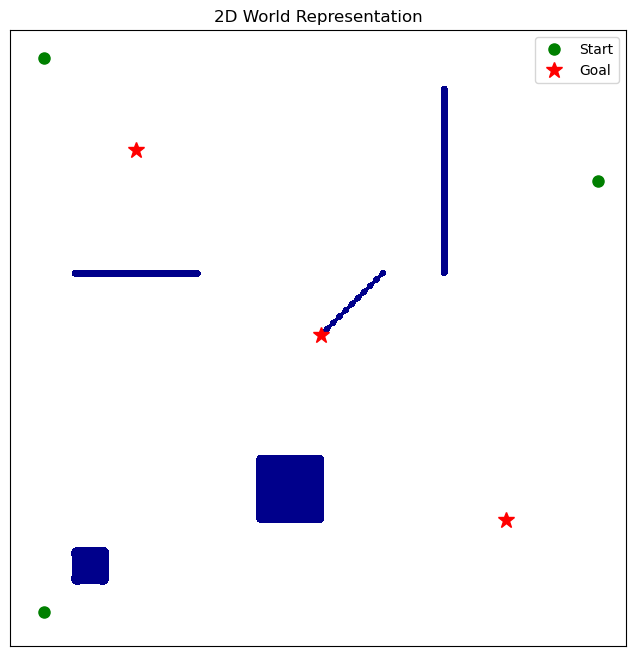


Starting Positions:
[(5, 5), (95, 75), (5, 95)]

Goal Positions:
[(80, 20), (20, 80), (50, 50)]


In [54]:

# Create a 100 x 100 world
world = World(width=100, height=100)

# --- Add Obstacles ---
# Add a rectangular obstacle from row 20 to 30 and column 40 to 50
for i in range(20, 31):
    for j in range(40, 51):
        world.set_obstacle(i, j)

# Add a horizontal bar obstacle at row 60 from column 10 to 30
for j in range(10, 31):
    world.set_obstacle(60, j)

# Add a vertical bar obstacle at column 70 from row 60 to 90
for i in range(60, 91):
    world.set_obstacle(i, 70)

# Add a square obstacle from (10, 10) to (15, 15)
for i in range(10, 16):
    for j in range(10, 16):
        world.set_obstacle(i, j)

# Add a diagonal obstacle from (50, 50) to (60, 60)
for offset in range(0, 11):
    i = 50 + offset
    j = 50 + offset
    world.set_obstacle(i, j)

# --- Define Starting and Goal Spaces ---
# Add some starting positions
world.add_starting_position((5, 5))
world.add_starting_position((95, 75))
world.add_starting_position((5, 95))

# Add some goal positions
world.add_goal((80, 20))
world.add_goal((20, 80))
world.add_goal((50, 50))

# --- Display and Verify ---
print("World Grid:")
world.display_world()  # This prints the grid (0: free, 1: obstacle)

print("\nStarting Positions:")
print(world.starting_space)

print("\nGoal Positions:")
print(world.goal_space)

In [55]:
class Agent:
    """
    Represents an agent in the 2D world.

    When an Agent is initialized, it takes nominal start and goal coordinates
    (e.g., from the world's starting and goal spaces), but samples the actual
    start and goal from a 2D Gaussian around those coordinates. This introduces
    variability in both the agent's initial and final positions.

    Positions are then rounded to the nearest integer.
    """
    def __init__(
        self,
        agent_id,
        world,
        nominal_start,
        nominal_goal,
        start_std=1.0,
        goal_std=1.0, 
        random_seed=None
    ):
        """
        Parameters
        ----------
        agent_id : str or int
            Unique identifier for this agent.
        nominal_start : tuple
            (x, y) coordinates of the nominal start position.
        nominal_goal : tuple
            (x, y) coordinates of the nominal goal position.
        start_std : float, optional
            Standard deviation for sampling the actual start position.
        goal_std : float, optional
            Standard deviation for sampling the actual goal position.
        random_seed : int, optional
            Seed for reproducible sampling.
        """
        self.agent_id = agent_id
        self.nominal_start = nominal_start
        self.nominal_goal = nominal_goal
        self.start_std = start_std
        self.goal_std = goal_std
        self.world = world
        
        # Create a random generator for reproducible sampling
        self.rng = np.random.default_rng(random_seed)
        
        # Sample the actual start position and round to the nearest integer
        start_x = self.rng.normal(nominal_start[0], start_std)
        start_y = self.rng.normal(nominal_start[1], start_std)
        self.start = (
            int(np.rint(start_x)),
            int(np.rint(start_y))
        )
        
        # Sample the actual goal position and round to the nearest integer
        goal_x = self.rng.normal(nominal_goal[0], goal_std)
        goal_y = self.rng.normal(nominal_goal[1], goal_std)
        self.goal = (
            int(np.rint(goal_x)),
            int(np.rint(goal_y))
        )
    
    def __repr__(self):
        return (
            f"Agent(agent_id={self.agent_id}, "
            f"start={self.start}, "
            f"goal={self.goal})"
        )

    def get_positions(self):
        """
        Returns the actual start and goal positions for this agent.
        """
        return self.start, self.goal

    def plan_path(self, planner, **planner_kwargs):
        """
        Use a given planner (e.g., an instance of PathPlanner) to compute a path from the agent's start to its goal.
        Additional planner parameters can be passed as keyword arguments.
        """
        return planner.plan(self.start, self.goal, **planner_kwargs)

In [56]:
agent = Agent(
    agent_id=1,
    world=world,
    nominal_start=(5, 5),
    nominal_goal=(80, 20),
    start_std=2.0,
    goal_std=2.0,
    random_seed=42
)
print(agent)

Agent(agent_id=1, start=(6, 3), goal=(82, 22))


In [57]:
# Assume Node and get_neighbors are defined as follows:
class Node:
    """
    A node for the A* search.
    """
    def __init__(self, pos, g, h, parent=None):
        self.pos = pos  # (x, y)
        self.g = g      # Cost from start to current node.
        self.h = h      # Heuristic estimate to goal.
        self.f = g + h  # Total cost.
        self.parent = parent

    def __lt__(self, other):
        return self.f < other.f

def get_neighbors(pos, world):
    """
    Returns valid neighboring positions (4-connected grid) for a given position.
    Checks boundaries and obstacles using the world object.
    """
    x, y = pos
    # Moves: up, down, left, right.
    moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    neighbors = []
    for dx, dy in moves:
        new_x = x + dx
        new_y = y + dy
        if 0 <= new_x < world.width and 0 <= new_y < world.height:
            # Note: if world.grid is indexed as (row, col), then world.is_traversable(new_y, new_x)
            if world.is_traversable(new_y, new_x):
                neighbors.append((new_x, new_y))
    return neighbors

class PathPlanner:
    """
    A class that encapsulates the path planning algorithm.
    """
    def __init__(self, world, temperature=0.5, top_n=5):
        self.world = world  # The world instance, for obstacle checking.
        self.temperature = temperature
        self.top_n = top_n

    @staticmethod
    def cost(current, neighbor):
        """
        Cost between adjacent grid cells.
        Here, we assume a uniform cost of 1.
        """
        return 1

    @staticmethod
    def heuristic(pos, goal):
        """
        Compute the Manhattan distance between pos and goal.
        """
        return abs(pos[0] - goal[0]) + abs(pos[1] - goal[1])
    
    @staticmethod
    def boltzmann_sample(candidates, temperature):
        """
        Given a list of candidate nodes, sample one candidate according to a Boltzmann (softmax) distribution.
        """
        # Extract f-costs from candidates.
        f_costs = np.array([node.f for node in candidates])
        # Compute probabilities: lower f-cost should yield higher probability.
        probs = np.exp(-f_costs / temperature)
        probs /= np.sum(probs)
        index = np.random.choice(len(candidates), p=probs)
        return candidates[index]
    
    @staticmethod
    def stochastic_a_star(world, start, goal, temperature=0.5, top_n=5):
        """
        Compute a path from start to goal using a stochastic version of A*.
        """
        # Create the start node.
        start_node = Node(start, g=0, h=PathPlanner.heuristic(start, goal))
        open_list = [start_node]
        closed_set = set()
        
        while open_list:
            # Sort open_list by f-cost.
            open_list.sort(key=lambda node: node.f)
            # Get top_n candidates.
            candidates = open_list[:min(top_n, len(open_list))]
            # Sample one candidate using Boltzmann sampling.
            current = PathPlanner.boltzmann_sample(candidates, temperature)
            open_list.remove(current)
            closed_set.add(current.pos)
            
            if current.pos == goal:
                # Reconstruct path.
                path = []
                node = current
                while node is not None:
                    path.append(node.pos)
                    node = node.parent
                return path[::-1]
            
            for neighbor_pos in get_neighbors(current.pos, world):
                if neighbor_pos in closed_set:
                    continue
                tentative_g = current.g + PathPlanner.cost(current.pos, neighbor_pos)
                neighbor_node = Node(neighbor_pos, g=tentative_g, 
                                     h=PathPlanner.heuristic(neighbor_pos, goal),
                                     parent=current)
                # Check if a better path exists in open_list.
                if any(n.pos == neighbor_pos and n.f <= neighbor_node.f for n in open_list):
                    continue
                open_list.append(neighbor_node)
        
        return None  # No path found.
    
    def plan(self, start, goal):
        """
        Computes a path from start to goal using the stochastic A* algorithm.
        """
        path = PathPlanner.stochastic_a_star(self.world, start, goal, temperature=self.temperature, top_n=self.top_n)
        return path

In [58]:
planner = PathPlanner(world, temperature=0.5, top_n=5)

# The agent's plan_path method calls planner.plan with its own start and goal.
planned_path = agent.plan_path(planner)
print("Planned path for the agent:")

Planned path for the agent:


### Questions  
- Should the agents have sight in this simulation so they do not travel into walls?
- Is A* a good choice for agent movements?